In [1]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
from sklearn import preprocessing
from matplotlib import pyplot as plt

In [216]:
df = pd.read_csv('leg234_data.csv')
#Flip wrong datapoints
df['LATITUDE'] = np.where((df['LATITUDE']>=10) & (df['date'] >= '2022-02-13'), -df['LATITUDE'], df['LATITUDE'])

<div>
<img src="images/impurity.png" width="400"/>
<img src="images/permutation.png" width="400"/>
</div>

In [217]:
df = df.drop(columns=['NMEA.Wave_Height', 'PCO2.H2O_mmm', 'PCO2.atm_cond', 'NMEA.Wind_Speed', 'NMEA.Wind_Angle'])

In [ ]:
df_sat = df[['LATITUDE', 'LONGITUD', 'PDMEAN', 'FerryBox.Optode_Saturation', 'time', 'NMEA.Wind_Angle', 'NMEA.Wind_Speed', 'TOTAL']]
df_time = df[['LATITUDE', 'LONGITUD', 'PDMEAN', 'time', 'TOTAL']]
df_wind = df[['LATITUDE', 'LONGITUD', 'PDMEAN', 'NMEA.Wind_Angle', 'TOTAL']]



names = df_sat.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(df_sat)
df_sat = pd.DataFrame(scaled_df, columns=names)

In [ ]:
df = df[['LATITUDE', 'LONGITUD', 'PDMEAN', 'TOTAL']]
df

In [ ]:
y = df.iloc[:, df.columns == 'TOTAL']
X = df.iloc[:, df.columns != 'TOTAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state=123) 

In [121]:
def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train.values.ravel())

In [ ]:
forest_pred = forest.predict(X_val)
print('MAE score: ', mean_absolute_error(y_val, forest_pred))
print('R2 score: ', r2_score(y_val, forest_pred))
print('Smape score: ', smape(y_val, forest_pred.reshape(41194,1)))

In [ ]:
print('Parameters currently in use:\n')
print(forest.get_params())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
best_random = rf_random.best_estimator_

In [ ]:
r_pred = best_random.predict(X_val)
print('MAE score: ', mean_absolute_error(y_val, r_pred))
print('R2 score: ', r2_score(y_val, r_pred))
print('Smape score: ', smape(y_val, r_pred.reshape(41194,1)))

In [ ]:
clf = RandomForestRegressor(n_estimators=50, random_state=0, criterion='mae')

In [ ]:
clf.fit(X_train, y_train.values.ravel())

In [ ]:
clf_pred = clf.predict(X_val)
print('MAE score: ', mean_absolute_error(y_val, clf_pred))
print('R2 score: ', r2_score(y_val, clf_pred))
print('Smape score: ', smape(y_val, clf_pred.reshape(41194,1)))

# Creating different datasets
### North and South Atlantic
### Max 600m depth
### Keep rows with some NaNs (remove harbour dates and where all values are NaN

In [218]:
# Filter original dataframe. Return dataframe where lat / long is higher than given
def df_by_position(df, min_lat = None, max_lat = None, min_long = None, max_long = None):
    if min_lat:
        df = df[df['LATITUDE'] >= min_lat] 
    if min_long: 
        df = df[df['LONGITUD'] >= min_long] 
    if max_lat:
        df = df[df['LATITUDE'] <= max_lat] 
    if max_long:
        df = df[df['LONGITUD'] <= max_long] 
    return df

# Return df with max depth given
def df_by_depth(df, max_depth = None):
    if max_depth:
        df = df[df['PDMEAN'] <= max_depth] 
    return df

def df_specific_depth(df, depth):
    df = df[df['PDMEAN'] == depth] 
    df = df[['LATITUDE','LONGITUD','PDMEAN', 'TOTAL', 'date']]
    return df

In [219]:
north = df_by_position(df, min_lat=0)
mid_atlantic = df_by_position(df, min_lat = -3, max_lat = 15, min_long = -44, max_long = -28)
carib = df_by_position(df, min_lat = 15, max_lat = 25, min_long = -85, max_long = -70)
shallow = df_by_depth(df, 600)
depth = df_specific_depth(df, 545)


In [86]:
# Negate latitudes where lat > 10 and date > 2022-02-13. These values are flipped in the original dataset
depth['LATITUDE'] = np.where((depth['LATITUDE']>=10) & (depth['date'] >= '2022-02-13'), -depth['LATITUDE'], depth['LATITUDE'])

depth

,LATITUDE,LONGITUD,PDMEAN,TOTAL,date
107,27.19902,-16.89221,545.0,39.4535,2021-10-05
179,27.18716,-16.90512,545.0,8.1044,2021-10-05
251,27.17516,-16.91777,545.0,47.7747,2021-10-05
323,27.16312,-16.93052,545.0,14.6120,2021-10-05
395,27.15121,-16.94351,545.0,2.3619,2021-10-05
...,...,...,...,...,...
284261,-23.05455,-40.34803,545.0,53.0708,2022-02-19
284334,-23.09309,-40.42757,545.0,81.4140,2022-02-19
284407,-23.11807,-40.51249,545.0,42.3239,2022-02-19
284480,-23.16949,-40.58302,545.0,44.7797,2022-02-19


In [220]:
south = df_by_position(df, max_lat=1)
south

,LATITUDE,LONGITUD,PDMEAN,TOTAL,PCO2.CO2_umm,NMEA.Humidity,NMEA.Trykk,FerryBox.SBE45_Salinity,FerryBox.SBE45_Conductivity,FerryBox.Optode_Saturation,FerryBox.C3_Turbidity,FerryBox.C3_CHLAFluorescence,FerryBox.C3_Temperature,FerryBox.C3_CDOMFluorescence,date,day,month,time
264716,-3.54215,-30.48989,7.5,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-10,10,2,13.0
264717,-3.54215,-30.48989,15.0,11.0921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-10,10,2,13.0
264718,-3.54215,-30.48989,25.0,21.4659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-10,10,2,13.0
264719,-3.54215,-30.48989,35.0,19.6041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-10,10,2,13.0
264720,-3.54215,-30.48989,45.0,4.7807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-10,10,2,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284567,-23.19454,-40.66192,685.0,35.0402,417.429993,85.566666,1008.799988,35.882,5.796,94.059998,-0.38,-0.45,28.41,-0.15,2022-02-19,19,2,21.0
284568,-23.19454,-40.66192,695.0,45.1827,417.429993,85.566666,1008.799988,35.882,5.796,94.059998,-0.38,-0.45,28.41,-0.15,2022-02-19,19,2,21.0
284569,-23.19454,-40.66192,705.0,351.3631,417.429993,85.566666,1008.799988,35.882,5.796,94.059998,-0.38,-0.45,28.41,-0.15,2022-02-19,19,2,21.0
284570,-23.19454,-40.66192,715.0,42.6268,417.429993,85.566666,1008.799988,35.882,5.796,94.059998,-0.38,-0.45,28.41,-0.15,2022-02-19,19,2,21.0


,LATITUDE,LONGITUD,PDMEAN,TOTAL,PCO2.CO2_umm,NMEA.Humidity,NMEA.Trykk,FerryBox.SBE45_Salinity,FerryBox.SBE45_Conductivity,FerryBox.Optode_Saturation,FerryBox.C3_Turbidity,FerryBox.C3_CHLAFluorescence,FerryBox.C3_Temperature,FerryBox.C3_CDOMFluorescence,date,day,month,time
74753,14.99664,-29.94162,7.5,0.0000,435.140015,72.283333,1013.434265,34.736000,5.384,93.260002,2.0,-0.49,28.83,-0.15,2021-10-12,12,10,17.0
74754,14.99664,-29.94162,15.0,16.5579,435.140015,72.283333,1013.434265,34.736000,5.384,93.260002,2.0,-0.49,28.83,-0.15,2021-10-12,12,10,17.0
74755,14.99664,-29.94162,25.0,22.2363,435.140015,72.283333,1013.434265,34.736000,5.384,93.260002,2.0,-0.49,28.83,-0.15,2021-10-12,12,10,17.0
74756,14.99664,-29.94162,35.0,22.7564,435.140015,72.283333,1013.434265,34.736000,5.384,93.260002,2.0,-0.49,28.83,-0.15,2021-10-12,12,10,17.0
74757,14.99664,-29.94162,45.0,34.5987,435.140015,72.283333,1013.434265,34.736000,5.384,93.260002,2.0,-0.49,28.83,-0.15,2021-10-12,12,10,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275588,14.92918,-35.05732,685.0,20.3079,417.429993,65.683334,1010.283997,36.231998,5.932,94.500000,-0.4,-0.45,29.16,-0.17,2022-02-15,15,2,7.5
275589,14.92918,-35.05732,695.0,20.6968,417.429993,65.683334,1010.283997,36.231998,5.932,94.500000,-0.4,-0.45,29.16,-0.17,2022-02-15,15,2,7.5
275590,14.92918,-35.05732,705.0,28.9461,417.429993,65.683334,1010.283997,36.231998,5.932,94.500000,-0.4,-0.45,29.16,-0.17,2022-02-15,15,2,7.5
275591,14.92918,-35.05732,715.0,19.3970,417.429993,65.683334,1010.283997,36.231998,5.932,94.500000,-0.4,-0.45,29.16,-0.17,2022-02-15,15,2,7.5


In [236]:
depth = gpd.GeoDataFrame(
    depth, geometry=gpd.points_from_xy(depth.LATITUDE, depth.LONGITUD))

depth.reset_index(level=0, inplace=True)

depth['date'] = depth['date'].astype(str)

depth = depth.dropna()

In [237]:
depth

,index,LATITUDE,LONGITUD,PDMEAN,TOTAL,date,geometry
0,107,27.19902,-16.89221,545.0,39.4535,2021-10-05,POINT (27.19902 -16.89221)
1,179,27.18716,-16.90512,545.0,8.1044,2021-10-05,POINT (27.18716 -16.90512)
2,251,27.17516,-16.91777,545.0,47.7747,2021-10-05,POINT (27.17516 -16.91777)
3,323,27.16312,-16.93052,545.0,14.6120,2021-10-05,POINT (27.16312 -16.93052)
4,395,27.15121,-16.94351,545.0,2.3619,2021-10-05,POINT (27.15121 -16.94351)
...,...,...,...,...,...,...,...
3777,284261,-23.05455,-40.34803,545.0,53.0708,2022-02-19,POINT (-23.05455 -40.34803)
3778,284334,-23.09309,-40.42757,545.0,81.4140,2022-02-19,POINT (-23.09309 -40.42757)
3779,284407,-23.11807,-40.51249,545.0,42.3239,2022-02-19,POINT (-23.11807 -40.51249)
3780,284480,-23.16949,-40.58302,545.0,44.7797,2022-02-19,POINT (-23.16949 -40.58302)


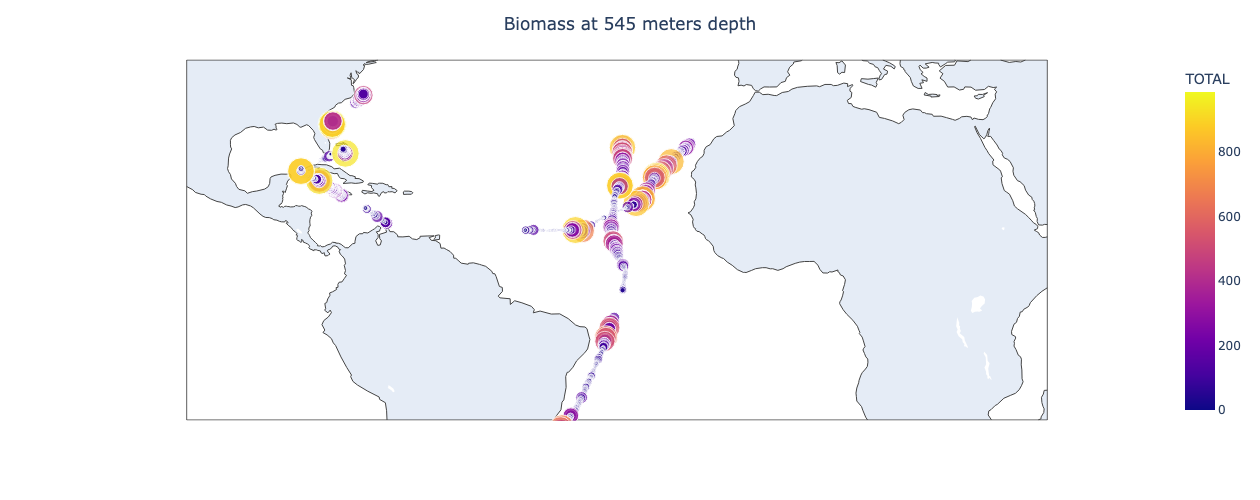

In [238]:
#fig = px.scatter_geo(depth,lat='LATITUDE',lon='LONGITUD', hover_name="TOTAL")
fig = px.scatter_geo(depth,
                    lat=depth.geometry.x,
                    lon=depth.geometry.y,
                    color="TOTAL",
                    size='TOTAL',
                    hover_data=['TOTAL', 'date'])
fig.update_geos(
    center=dict(lon=-30, lat=10),
    lataxis_range=[-30,30], lonaxis_range=[-100, 50]
)
fig.update_layout(title = 'Biomass at 545 meters depth', title_x=0.5, height=500,
                 )
fig.show()



In [117]:
def split_data(df):
    y = df.iloc[:, df.columns == 'TOTAL']
    X = df.iloc[:, df.columns != 'TOTAL']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
        test_size=0.25, random_state=123) 
    

    return X_train, X_val, y_train, y_val

In [118]:
def fit_forest(X_train, y_train):
    forest = RandomForestRegressor(random_state=0)
    forest.fit(X_train, y_train.values.ravel())
    return forest

In [119]:
def predict_and_score(X_val, y_val, forest):
    r_pred = forest.predict(X_val)
    print('MAE score: ', mean_absolute_error(y_val, r_pred))
    print('R2 score: ', r2_score(y_val, r_pred))
    print('Smape score: ', smape(y_val, r_pred.reshape(len(X_val),1)))

In [ ]:
X_train, X_val, y_train, y_val = split_data(shallow)
forest = fit_forest(X_train, y_train)

In [ ]:
predict_and_score(X_val, y_val, forest)

# Removing dates when ship was in port

In [221]:
data = {'Port':['La Coruna', 'Lisbon', 'Cadiz', 'Las Palmas', 'Willemstad',
                'Port Royal', 'Havana', 'Nassau', 'Miami', 'New York',
                'New Port', 'Horta', 'Rio'], 'Date from':['28.08.2021', '02.09.2021', '09.09.2021',
                '30.09.2021', '04.11.2021', '13.11.2021', '24.11.2021', '02.12.2021', '07.12.2021',
                '18.12.2021', '05.01.2022', '22.01.2022', '23.02.2022'],
                'Date to':['29.08.2021', '05.09.2021', '16.09.2021', '04.10.2021', '08.11.2021','17.11.2021',
                '28.11.2021', '05.12.2021', '10.12.2021', '04.01.2022', '08.01.2022', '24.01.2022', '26.02.2022']}

In [222]:
df_ports = pd.DataFrame(data)

In [223]:
df_ports

,Port,Date from,Date to
0,La Coruna,28.08.2021,29.08.2021
1,Lisbon,02.09.2021,05.09.2021
2,Cadiz,09.09.2021,16.09.2021
3,Las Palmas,30.09.2021,04.10.2021
4,Willemstad,04.11.2021,08.11.2021
5,Port Royal,13.11.2021,17.11.2021
6,Havana,24.11.2021,28.11.2021
7,Nassau,02.12.2021,05.12.2021
8,Miami,07.12.2021,10.12.2021
9,New York,18.12.2021,04.01.2022


In [224]:
df_ports['Date from'] = pd.to_datetime(df_ports['Date from'], dayfirst=True, format='%d.%m.%Y')
df_ports['Date to'] = pd.to_datetime(df_ports['Date to'], dayfirst=True, format='%d.%m.%Y')


In [227]:
def remove_ports_df(ports, df):
    df['date'] = pd.to_datetime(df['date'])
    for idx, row in ports.iterrows():
        from_date = row['Date from']
        to_date = row['Date to']
        #df = df.drop([(df['date'] <= from_date) & (df['date'] >= to_date)])
        df = df[(df['date'] < from_date) | (df['date'] > to_date)]
        
    #Fill median, drop rows with missing EK data
    #df = df.dropna(subset=['TOTAL'])
   # df = df.drop(columns=['date'])
   # df = df.fillna(df.median())
    return df
        

In [229]:

south = remove_ports_df(df_ports, south)
south = south.dropna(subset=['TOTAL'])
south = south.drop(columns=['date'])
south = south.fillna(df.median())

In [141]:
carib['date'] = pd.to_datetime(carib['date'])
mid_atlantic['date'] = pd.to_datetime(mid_atlantic['date'])


In [142]:
carib = remove_ports_df(df_ports, carib)
mid_atlantic = remove_ports_df(df_ports, mid_atlantic)

In [230]:
south

,LATITUDE,LONGITUD,PDMEAN,TOTAL,PCO2.CO2_umm,NMEA.Humidity,NMEA.Trykk,FerryBox.SBE45_Salinity,FerryBox.SBE45_Conductivity,FerryBox.Optode_Saturation,FerryBox.C3_Turbidity,FerryBox.C3_CHLAFluorescence,FerryBox.C3_Temperature,FerryBox.C3_CDOMFluorescence,day,month,time
264716,-3.54215,-30.48989,7.5,0.0000,417.429993,74.600002,1011.994019,35.775002,5.673,94.510002,0.96,-0.50,28.83,-0.15,10,2,13.0
264717,-3.54215,-30.48989,15.0,11.0921,417.429993,74.600002,1011.994019,35.775002,5.673,94.510002,0.96,-0.50,28.83,-0.15,10,2,13.0
264718,-3.54215,-30.48989,25.0,21.4659,417.429993,74.600002,1011.994019,35.775002,5.673,94.510002,0.96,-0.50,28.83,-0.15,10,2,13.0
264719,-3.54215,-30.48989,35.0,19.6041,417.429993,74.600002,1011.994019,35.775002,5.673,94.510002,0.96,-0.50,28.83,-0.15,10,2,13.0
264720,-3.54215,-30.48989,45.0,4.7807,417.429993,74.600002,1011.994019,35.775002,5.673,94.510002,0.96,-0.50,28.83,-0.15,10,2,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284567,-23.19454,-40.66192,685.0,35.0402,417.429993,85.566666,1008.799988,35.882000,5.796,94.059998,-0.38,-0.45,28.41,-0.15,19,2,21.0
284568,-23.19454,-40.66192,695.0,45.1827,417.429993,85.566666,1008.799988,35.882000,5.796,94.059998,-0.38,-0.45,28.41,-0.15,19,2,21.0
284569,-23.19454,-40.66192,705.0,351.3631,417.429993,85.566666,1008.799988,35.882000,5.796,94.059998,-0.38,-0.45,28.41,-0.15,19,2,21.0
284570,-23.19454,-40.66192,715.0,42.6268,417.429993,85.566666,1008.799988,35.882000,5.796,94.059998,-0.38,-0.45,28.41,-0.15,19,2,21.0


In [231]:
X_train, X_val, y_train, y_val = split_data(south)
forest = fit_forest(X_train, y_train)
predict_and_score(X_val, y_val, forest)

MAE score:  21.33817806419554
R2 score:  0.7047914975745762
Smape score:  TOTAL    0.363172
dtype: float64


In [232]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

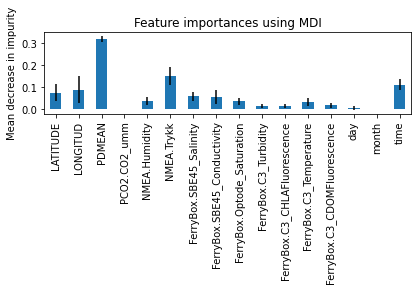

In [233]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [234]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_val, y_val, n_repeats=10, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

Elapsed time to compute the importances: 18.073 seconds


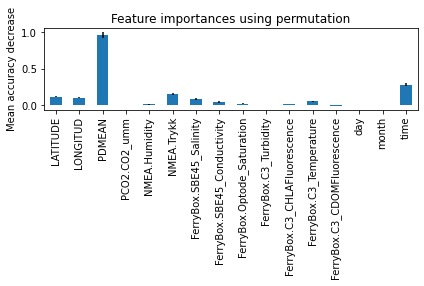

In [235]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [144]:
X_train, X_val, y_train, y_val = split_data(mid_atlantic)
forest = fit_forest(X_train, y_train)
predict_and_score(X_val, y_val, forest)

MAE score:  12.349774162565605
R2 score:  0.6764080341061518
Smape score:  TOTAL    0.365089
dtype: float64


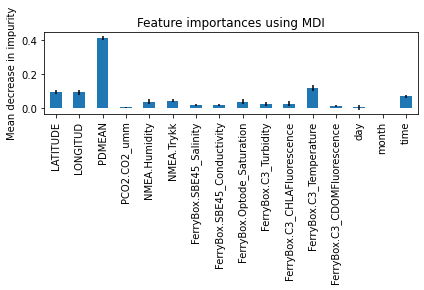

In [145]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [146]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_val, y_val, n_repeats=10, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

Elapsed time to compute the importances: 73.575 seconds


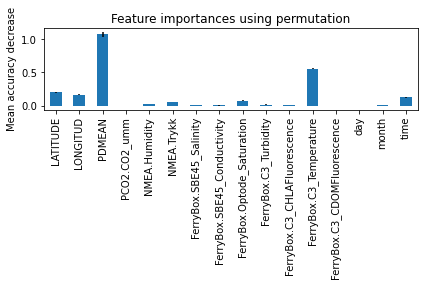

In [147]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()